In [42]:
import numpy as np
import os
import sys
!pip install aesthetix
import aesthetix as at
import pandas as pd

In [2]:
"""This is a new collection of translated movie subtitles from http://www.opensubtitles.org/.
IMPORTANT: If you use the OpenSubtitle corpus:
Please, add a link to http://www.opensubtitles.org/ to your website and to your reports and publications produced with the data! I promised this when I got the data from the providers of that website!"""
!wget http://opus.nlpl.eu/download.php?f=OpenSubtitles/v2018/mono/OpenSubtitles.raw.en.gz
!gunzip -k download.php?f=OpenSubtitles%2Fv2018%2Fmono%2FOpenSubtitles.raw.en.gz


--2020-06-30 07:31:58--  http://opus.nlpl.eu/download.php?f=OpenSubtitles/v2018/mono/OpenSubtitles.raw.en.gz
Resolving opus.nlpl.eu (opus.nlpl.eu)... 193.166.25.9
Connecting to opus.nlpl.eu (opus.nlpl.eu)|193.166.25.9|:80... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://object.pouta.csc.fi/OPUS-OpenSubtitles/v2018/mono/en.txt.gz [following]
--2020-06-30 07:31:58--  https://object.pouta.csc.fi/OPUS-OpenSubtitles/v2018/mono/en.txt.gz
Resolving object.pouta.csc.fi (object.pouta.csc.fi)... 86.50.254.18, 86.50.254.19
Connecting to object.pouta.csc.fi (object.pouta.csc.fi)|86.50.254.18|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 3663376519 (3.4G) [application/gzip]
Saving to: ‘download.php?f=OpenSubtitles%2Fv2018%2Fmono%2FOpenSubtitles.raw.en.gz’

download.php?f=Open 100%[===================>]   3.41G  22.9MB/s    in 2m 32s  

2020-06-30 07:34:31 (23.0 MB/s) - ‘download.php?f=OpenSubtitles%2Fv2018%2Fmono%2FOpenSubtitles.raw.en.gz

In [ ]:
# os.mkdir('/tmp/lines')
!split -a 3 -l 100000 download.php?f=OpenSubtitles%2Fv2018%2Fmono%2FOpenSubtitles.raw.en /tmp/lines/lines-

In [60]:
texts = []
for file in (os.listdir('/tmp/lines'))[:50]:
  path = os.path.join('/tmp/lines', file)
  if sys.version_info < (3,):
    f = open(path)
  else:
    f = open(path, encoding='latin-1')
  for line in f:
    stripped_line = line.strip()
    texts.append(stripped_line)
  f.close()

msg = []
reply = []
for file in (os.listdir('/tmp/lines'))[:50]:
  path = os.path.join('/tmp/lines', file)
  tfile = open(path,'r')
  txt = tfile.readlines()
  for i,lines in enumerate(txt[:-1]):
    lines = lines.strip('\n')
    lines = lines.lower()
    lines = lines.replace(".", " ")
    lines = lines.replace(",", " ")
    lines = lines.replace("?", " ")
    lines = lines.replace("!", " ")
    lines = lines.replace(":", " ")
    lines = lines.replace(">", " ")
    lines = lines.replace("<", " ")
    lines = lines.replace("-", " ")
    lines = lines.replace("_", " ")
    lines = lines.replace("\\", " ")
    lines = lines.replace("  ", " ")
    lines = "startseq " + lines + " endseq"
    lines2 = "startseq " + txt[i+1]
    lines2 = lines2.strip('\n')
    lines2 = lines2.lower()
    lines2 = lines2.replace(".", " ")
    lines2 = lines2.replace(",", " ")
    lines2 = lines2.replace("?", " ")
    lines2 = lines2.replace("!", " ")
    lines2 = lines2.replace(":", " ")
    lines2 = lines2.replace(">", " ")
    lines2 = lines2.replace("<", " ")
    lines2 = lines2.replace("-", " ")
    lines2 = lines2.replace("_", " ")
    lines2 = lines2.replace("\\", " ")
    lines2 = lines2.replace("  ", " ")
    # print(lines)
    msg.append(lines)
    reply.append(lines2)
  tfile.close()

In [61]:
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences

tokenizer = Tokenizer(num_words= 5000, oov_token = "<OOV>", lower=True, split=' ')
tokenizer.fit_on_texts(msg)

sequences = tokenizer.texts_to_sequences(msg[:10000])

word_index = tokenizer.word_index
print('Found %s unique tokens.' % len(word_index))

sequences = tokenizer.texts_to_sequences(msg[:10000])
inputmsg = pad_sequences(sequences, padding='post', maxlen =20, truncating='post')
sequences = tokenizer.texts_to_sequences(reply[:10000])
outputlabels = pad_sequences(sequences, padding='post', maxlen =20, truncating='post')

index_to_word = {}
for word,index in word_index.items():
  index_to_word[index] = word

Found 122366 unique tokens.


In [62]:
from gensim.test.utils import common_texts
from gensim.corpora.dictionary import Dictionary
from gensim.models.ldamodel import LdaModel
from keras.layers import Embedding

# Create a corpus from a list of texts
common_dictionary = Dictionary(common_texts)
common_corpus = [common_dictionary.doc2bow(text) for text in common_texts]

# Train the model on the corpus.
lda = LdaModel(common_corpus, num_topics=10)

# Save a model to disk, or reload a pre-trained model
from gensim.test.utils import datapath

# Save model to disk.
temp_file = datapath("model")
lda.save(temp_file)

# Load a potentially pretrained model from disk.
lda = LdaModel.load(temp_file)

# Create a new corpus, made of previously unseen documents.
def corpus(seq, verbose = False):
  ldacorpus=[]
  for i, sen in enumerate(seq):
    counts = [list(sen).count(elt) for elt in sen]
    sentence = list(set([(sen[i], counts[i]) for j in range(len(counts))]))
    ldacorpus.append(sentence)
    return ldacorpus
# other_texts = [
#               ['computer', 'time', 'graph'],
#               ['survey', 'response', 'eps'],
#               ['human', 'system', 'computer']
#               ]
# other_corpus = [common_dictionary.doc2bow(text) for text in other_texts]

# unseen_doc = other_corpus[0]
# vector = lda[unseen_doc]  # get topic probability distribution for a document

# # Update the model by incrementally training on the new corpus

# lda.update(other_corpus)
# vector = lda[unseen_doc]

# A lot of parameters can be tuned to optimize training for your specific case
lda_corpus = corpus(inputmsg, verbose = True)
lda = LdaModel(lda_corpus, num_topics=50, id2word=index_to_word)  # learn asymmetric alpha from data

/usr/local/lib/python3.6/dist-packages/smart_open/smart_open_lib.py:253: UserWarning: This function is deprecated, use smart_open.open instead. See the migration notes for details: https://github.com/RaRe-Technologies/smart_open/blob/master/README.rst#migrating-to-the-new-open-function
  'See the migration notes for details: %s' % _MIGRATION_NOTES_URL
/usr/local/lib/python3.6/dist-packages/gensim/models/ldamodel.py:807: RuntimeWarning: overflow encountered in exp2
  perwordbound, np.exp2(-perwordbound), len(chunk), corpus_words


In [63]:
lda.save("Lda")

/usr/local/lib/python3.6/dist-packages/smart_open/smart_open_lib.py:253: UserWarning: This function is deprecated, use smart_open.open instead. See the migration notes for details: https://github.com/RaRe-Technologies/smart_open/blob/master/README.rst#migrating-to-the-new-open-function
  'See the migration notes for details: %s' % _MIGRATION_NOTES_URL


In [64]:
print(lda_corpus)

[[(2, 1)]]


In [65]:
print(lda)

LdaModel(num_terms=122367, num_topics=50, decay=0.5, chunksize=2000)


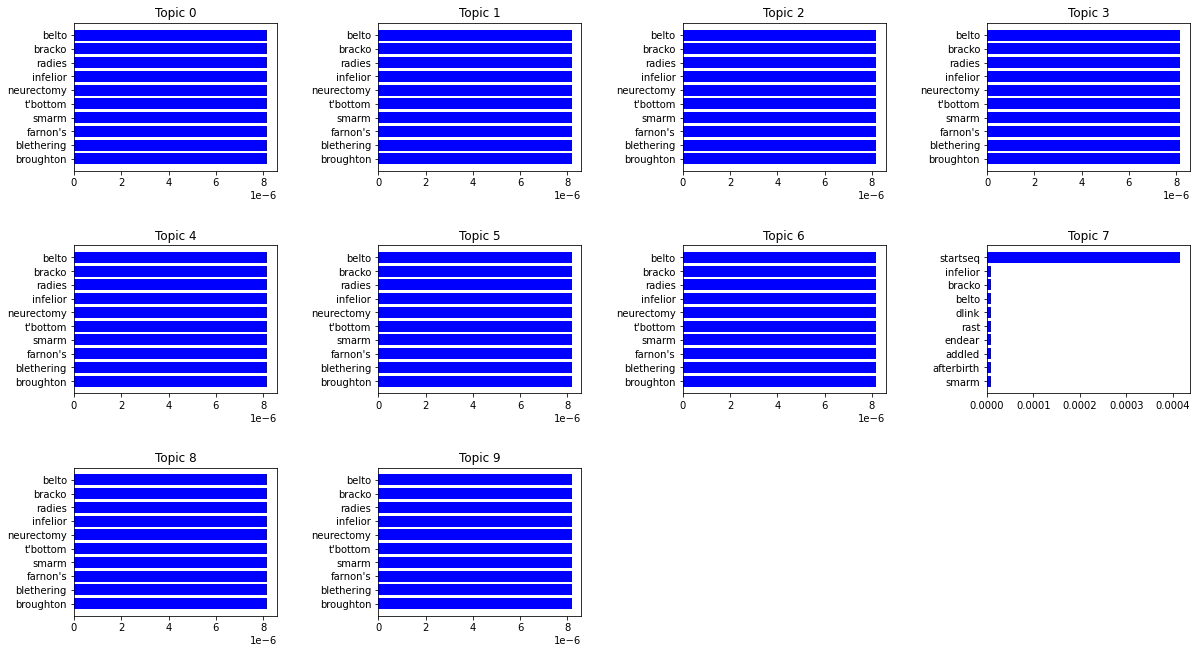

In [67]:
from matplotlib import pyplot as plt, gridspec
import math

def plot_top_words(lda=lda, nb_topics=10, nb_words=10):
    top_words = [[word for word,_ in lda.show_topic(topic_id, topn=50)] for topic_id in range(lda.num_topics)]
    top_betas = [[beta for _,beta in lda.show_topic(topic_id, topn=50)] for topic_id in range(lda.num_topics)]

    gs  = gridspec.GridSpec(round(math.sqrt(nb_topics))+1,round(math.sqrt(nb_topics))+1)
    gs.update(wspace=0.5, hspace=0.5)
    plt.figure(figsize=(20,15))
    for i in range(nb_topics):
        ax = plt.subplot(gs[i])
        plt.barh(range(nb_words), top_betas[i][:nb_words], align='center',color='blue', ecolor='black')
        ax.invert_yaxis()
        ax.set_yticks(range(nb_words))
        ax.set_yticklabels(top_words[i][:nb_words])
        plt.title("Topic "+str(i))
        
  
plot_top_words()


--2020-06-30 11:42:47--  https://raw.githubusercontent.com/nltk/nltk_data/gh-pages/packages/corpora/stopwords.zip
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 151.101.0.133, 151.101.64.133, 151.101.128.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|151.101.0.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 23047 (23K) [application/zip]
Saving to: ‘stopwords.zip.4’

stopwords.zip.4     100%[===================>]  22.51K  --.-KB/s    in 0.01s   

2020-06-30 11:42:47 (1.86 MB/s) - ‘stopwords.zip.4’ saved [23047/23047]

NLTK Downloader
---------------------------------------------------------------------------
    d) Download   l) List    u) Update   c) Config   h) Help   q) Quit
---------------------------------------------------------------------------
Downloader> q


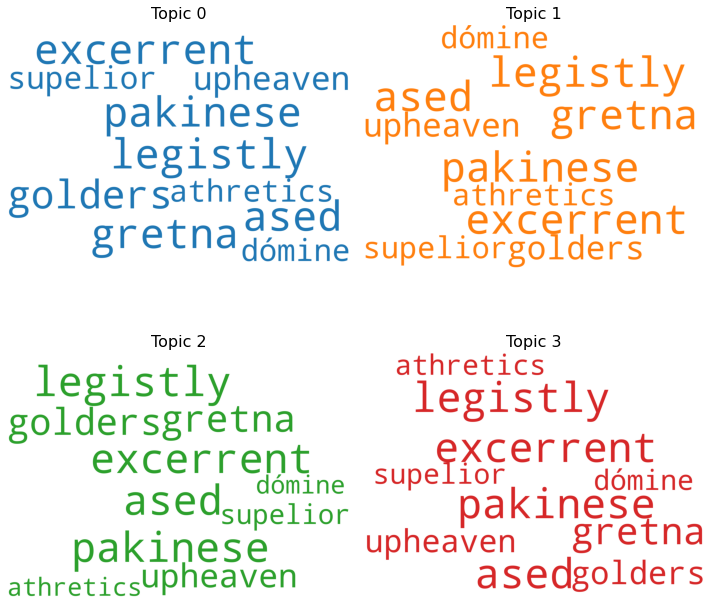

In [68]:
#Word Clouds of Top N Keywords in Each Topic
from matplotlib import pyplot as plt
from wordcloud import WordCloud, STOPWORDS
import matplotlib.colors as mcolors
#stopwords package download
!wget https://raw.githubusercontent.com/nltk/nltk_data/gh-pages/packages/corpora/stopwords.zip
import nltk
nltk.download()
from nltk.corpus import stopwords
stop_words = stopwords.words('english')
cols = [color for name, color in mcolors.TABLEAU_COLORS.items()]  # more colors: 'mcolors.XKCD_COLORS'

cloud = WordCloud(stopwords=stop_words,
                  background_color='white',
                  width=2500,
                  height=1800,
                  max_words=10,
                  colormap='tab10',
                  color_func=lambda *args, **kwargs: cols[i],
                  prefer_horizontal=1.0)

topics = lda.show_topics(formatted=False)

fig, axes = plt.subplots(2, 2, figsize=(10,10), sharex=True, sharey=True)

for i, ax in enumerate(axes.flatten()):
    fig.add_subplot(ax)
    topic_words = dict(topics[i][1])
    cloud.generate_from_frequencies(topic_words, max_font_size=300)
    plt.gca().imshow(cloud)
    plt.gca().set_title('Topic ' + str(i), fontdict=dict(size=16))
    plt.gca().axis('off')


plt.subplots_adjust(wspace=0, hspace=0)
plt.axis('off')
plt.margins(x=0, y=0)
plt.tight_layout()
plt.show()